In [55]:
import numpy as np
import pmcx
import jdata as jd
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from scipy.ndimage import median_filter
pmcx.gpuinfo()

=============================   GPU Information  ================================
Device 1 of 1:		NVIDIA GeForce RTX 4090
Compute Capability:	8.9
Global Memory:		25268649984 B
Constant Memory:	65536 B
Shared Memory:		49152 B
Registers:		65536
Clock Speed:		2.52 GHz
Number of SMs:		128
Number of Cores:	16384
Auto-thread:		524288
Auto-block:		64


[{'name': 'NVIDIA GeForce RTX 4090',
  'id': 1,
  'devcount': 1,
  'major': 8,
  'minor': 9,
  'globalmem': 25268649984,
  'constmem': 65536,
  'sharedmem': 49152,
  'regcount': 65536,
  'clock': 2520000,
  'sm': 128,
  'core': 16384,
  'autoblock': 64,
  'autothread': 524288,
  'maxgate': 0}]

In [56]:
def fft_gauss(in_arrayOriginal, kernel_size):
    '''
    Perform FFR Gauss low-pass filtering

    in_array: input image
    kernel_size: kernel size for smoothing
    '''
    if kernel_size > 0:
        in_NaNs = np.isnan(in_arrayOriginal)
        in_array = np.copy(in_arrayOriginal)
        in_array[np.isinf(in_array)] = 0
        in_array[np.isnan(in_array)] = 0

        # FFT filter
        im_fft = np.fft.fft2(in_array)
        im_rfft_filtered = ndimage.fourier_gaussian(im_fft, kernel_size)
        im_filtered = np.fft.ifft2(im_rfft_filtered)

        # Power spectrum
        pwr_spectrum = abs(np.fft.fftshift(im_fft))**2
        pwr_spectrum_filtered = abs(np.fft.fftshift(im_rfft_filtered))**2

        # Re-normalization
        sum_ratio = in_array.sum()/im_filtered.sum()
        im_filtered = im_filtered*sum_ratio
        del in_array

        im_output = np.full(np.shape(im_filtered), fill_value=np.NaN)
        im_output[~in_NaNs] = im_filtered[~in_NaNs]
        del im_filtered, in_NaNs

        return im_output, pwr_spectrum, pwr_spectrum_filtered
    else:
        return in_arrayOriginal, 0, 0


In [57]:
def mcxdettime(detp, prop, unitinmm=1):
    """
    Recalculate the detected photon time using partial path data and
    optical properties (for perturbation Monte Carlo or detector readings).

    Parameters:
    detp : dict
        The 2nd output from mcxlab, detp must be a dictionary.
    prop : ndarray
        Optical property list, as defined in the cfg.prop field of mcxlab's input.
    unitinmm : float, optional
        Voxel edge-length in mm, should use cfg.unitinmm used to generate detp;
        default is 1 mm.

    Returns:
    dett : ndarray
        Recalculated detected photon time based on the partial path data and optical property table.
    """
    R_C0 = 3.335640951981520e-12  # inverse of light speed in vacuum

    # Check if 'prop' is provided in detp, if not, check if it's explicitly given
    if 'prop' not in detp and prop is None:
        raise ValueError('must provide input "prop"')

    # Assign 'prop' from detp if not given
    if prop is None:
        prop = detp['prop']

    # Check if 'unitinmm' is provided in detp, if not, use the default or the provided value
    if 'unitinmm' in detp:
        unitinmm = detp['unitinmm']

    # Check if 'ppath' field exists in detp
    if 'ppath' not in detp:
        raise ValueError('the first input must be a dict with a subfield named "ppath"')

    # Calculate the detected times
    medianum = prop.shape[0]
    if medianum <= 1:
        raise ValueError('empty property list')

    dett = np.zeros(detp['ppath'].shape[0])
    for i in range(medianum - 1):
        dett += prop[i + 1, 3] * detp['ppath'][:, i] * R_C0 * unitinmm

    return dett

def mcxdetweight(detp, prop, unitinmm=1):
    """
    Recalculate the detected photon weight using partial path data and optical properties.
    
    Parameters:
    detp (dict): The 2nd output from mcxlab. Must be a dictionary with necessary fields.
    prop (np.ndarray): Optical property list.
    unitinmm (float): Voxel edge-length in mm. Defaults to 1 if not provided.
    
    Returns:
    np.ndarray: Recalculated detected photon weight.
    """
    
    # Check if 'prop' is provided
    if prop is None:
        if 'prop' in detp:
            prop = detp['prop']
        else:
            raise ValueError('must provide input "prop"')
    
    medianum = prop.shape[0]
    if medianum <= 1:
        raise ValueError('empty property list')
    
    # Check if 'unitinmm' is provided
    if unitinmm is None:
        if 'unitinmm' in detp:
            unitinmm = detp['unitinmm']
        else:
            unitinmm = 1
    
    # Initialize 'detw'
    if isinstance(detp, dict):
        if 'w0' not in detp:
            detw = np.ones(detp['ppath'].shape[0])
        else:
            detw = detp['w0']
        
        for i in range(medianum - 1):
            detw *= np.exp(-prop[i + 1, 0] * detp['ppath'][:, i] * unitinmm)
    else:
        raise ValueError('the first input must be a dictionary with a subfield named "ppath"')
    
    return detw

def mcxdettpsf(detp, detnum, prop, time):
    """
    Calculate the temporal point spread function (TPSF) curve of a specified detector.
    
    Parameters:
    detp (dict): The 2nd output from mcxlab. Must be a dictionary with 'detid' and 'ppath' subfields.
    detnum (int): Specified detector number.
    prop (np.ndarray): Optical property list.
    time (list or np.ndarray): Distribution of time bins, a 1x3 vector [tstart, tend, tstep].
    
    Returns:
    np.ndarray: Calculated temporal point spread function curve of the specified detector.
    """
    
    # Select the photon data of the specified detector
    mask = detp['detid'] == detnum
    detp['ppath'] = detp['ppath'][mask, :]
    detp['detid'] = detp['detid'][mask]
    
    # Calculate the detected photon weight and arrival time
    replayweight = mcxdetweight(detp, prop)
    replaytime = mcxdettime(detp, prop)
    
    # Define temporal point spread function vector
    nTG = round((time[1] - time[0]) / time[2])  # maximum time gate number
    tpsf = np.zeros(nTG)
    
    # Calculate the time bin, making sure not to exceed the boundary
    ntg = np.ceil((replaytime - time[0]) / time[2]).astype(int)
    ntg[ntg < 1] = 1
    ntg[ntg > nTG] = nTG
    
    # Add each photon weight to the corresponding time bin
    for i in range(len(replayweight)):
        tpsf[ntg[i] - 1] += replayweight[i]
    
    return tpsf

In [ ]:
def MCPHD (uaBulk, usBulk, g=0.9, n=1.4, sdSep = 20, slabThickness = 60, detRad = 3, isRefl = True, maxTime = 5e-9, nTimeBins=500, nPhotons = 1e8):
    maxSizeX = 100
    maxSizeY = 100
    maxSizeZ = 70
    initialLayerZ = 2
    cfg={}
    cfg['nphoton']=nPhotons
    cfg['vol']=np.zeros([maxSizeX, maxSizeY, maxSizeZ], dtype='uint8')
    cfg['tstart']=0
    cfg['tend']=5e-9
    cfg['tstep']=5e-9
    cfg['srcdir']=[0,0,1]
    cfg['issavedet']=1                         # cfg.issavedet must be set to 1 or True in order to save detected photons
    cfg['issrcfrom0']=1   

    cfg['vol'][:, :, initialLayerZ:slabThickness+initialLayerZ]=1
    cfg['srcpos']=[int(maxSizeX/2),int(maxSizeY/2),initialLayerZ]
    cfg['prop']=[[0, 0, 1, 1], [uaBulk, usBulk, g, n]]
    print(cfg['prop'])
    if isRefl:
        cfg['detpos']=[[int(maxSizeX/2)+sdSep,int(maxSizeY/2),initialLayerZ,detRad]]   # to detect photons, one must first define detectors 
    else:
        cfg['detpos']=[[int(maxSizeX/2)+sdSep,int(maxSizeY/2),initialLayerZ+slabThickness,detRad]]   # to detect photons, one must first define detectors  
    import time
    start = time.time()
    res=pmcx.mcxlab(cfg)
    
    maxTime = cfg['tend']
    binSize = maxTime/nTimeBins
    
    timeParams = [0, maxTime, binSize]
    timeBins = np.linspace(timeParams[0], timeParams[1], nTimeBins)
    
    times = mcxdettpsf(res['detp'], 1, cfg['prop'], timeParams)
    
    print("Simulation took {} seconds.".format(time.time()-start))
    #histo = np.histogram(times,bins=100, range=[0,maxTime])
    
    #return [histo[0]/np.sum(histo[0]), histo[1], cfg, res]
    return [times/np.sum(times), cfg, res], timeBins

In [59]:
histo, timeParams = MCPHD(uaBulk=0.04, usBulk=10, g=0.9, n=1.4, sdSep=20, slabThickness=60, detRad=3, isRefl=True, maxTime=5e-9, nPhotons=5e8, nTimeBins=4096)

[[0, 0, 1, 1], [0.04, 10, 0.9, 1.4]]
nphoton: 5e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
issrcfrom0: 1
issavedet: 1
Simulation took 15.902801275253296 seconds.


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2024 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io/                 #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

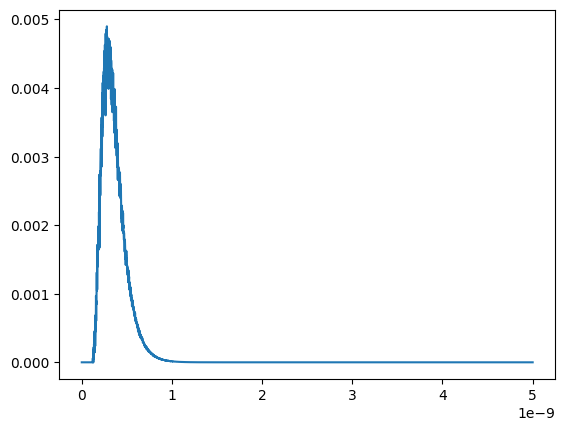

In [60]:
plt.plot(timeParams, histo[0])

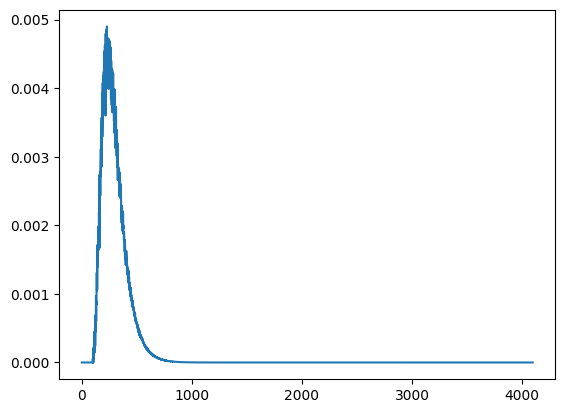

In [61]:
plt.plot(histo[0])